In [24]:
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import SimpleMovingAverage,AverageDollarVolume,Returns
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import Q1500US
from quantopian.pipeline.classifiers.morningstar import Sector
import alphalens as al
import numpy as np

MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}



In [16]:
class MyCustomFactor(CustomFactor):
    def compute(self,today,assets,out,close,returns):
        out[:] = ((close[-21] - close[-252])/close[-252] -
                      (close[-1] - close[-21])/close[-21]) / np.nanstd(returns, axis=0)

In [17]:
def make_pipeline():
    
    # Instantiate some values
    sector = Sector()
    universe = Q1500US()
    returns = Returns(window_length = 60)
    
    # Put your filters here
    adv = AverageDollarVolume(window_length=10)>5e8
    
    # Put your factors here
    price = USEquityPricing.close.latest
    sma = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=20,mask=universe)
    custom = MyCustomFactor(inputs=[USEquityPricing.close,returns],mask=universe,window_length=252)
    
    # Instanciate pipline
    pipe = Pipeline(screen = universe)
    
    # Add Factors and Filters to Pipeline
    pipe.add(USEquityPricing.close.latest,'price')
    pipe.add(adv,'adv')
    pipe.add(sma,'sma')
    pipe.add(sector,'sector')
    
    return pipe

In [18]:
result = run_pipeline(make_pipeline(),'2015-01-01', '2016-01-01')

In [19]:
my_factor = result['sma']
sectors = result['sector']
asset_list = result.index.levels[1].unique()

In [20]:
# Get prices and extend them to make sure we capture the whole period
prices = get_pricing(asset_list, start_date='2015-12-01', end_date='2016-02-01', fields='price')

In [21]:
factor_data = al.utils.get_clean_factor_and_forward_returns(my_factor,
                                                                   prices,
                                                                   quantiles=2,
                                                                   groupby=sectors,
                                                                   groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                                   periods=(1,5,10,20,30))

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.847250,43.502141,24.379333,10.793172,8910,50.014033
2,43.116622,1671.653000,95.443477,106.344413,8905,49.985967


Returns Analysis


,1,5,10,20,30
Ann. alpha,0.357,-0.035,-0.017,0.015,-0.098
beta,-0.131,-0.337,-0.306,-0.160,-0.329
Mean Period Wise Return Top Quantile (bps),11.837,28.283,21.403,106.697,205.310
Mean Period Wise Return Bottom Quantile (bps),-11.830,-28.267,-21.391,-106.637,-205.195
Mean Period Wise Spread (bps),23.635,11.254,4.251,10.681,13.676


Information Analysis


,1,5,10,20,30
IC Mean,0.056,0.068,0.025,0.129,0.203
IC Std.,0.169,0.136,0.113,0.062,0.041
t-stat(IC),1.145,1.739,0.766,7.209,17.073
p-value(IC),0.276,0.110,0.460,0.000,0.000
IC Skew,0.032,-0.432,0.492,-0.200,-0.041
IC Kurtosis,-1.397,-0.631,-0.872,-1.292,-1.092
Ann. IR,5.248,7.968,3.512,33.036,78.239


Turnover Analysis


,1,5,10,20,30
Quantile 1 Mean Turnover,0.002,0.008,0.018,NaN,NaN
Quantile 2 Mean Turnover,0.001,0.004,0.009,NaN,NaN


,1,5,10,20,30
Mean Factor Rank Autocorrelation,1.0,0.999,0.998,NaN,NaN


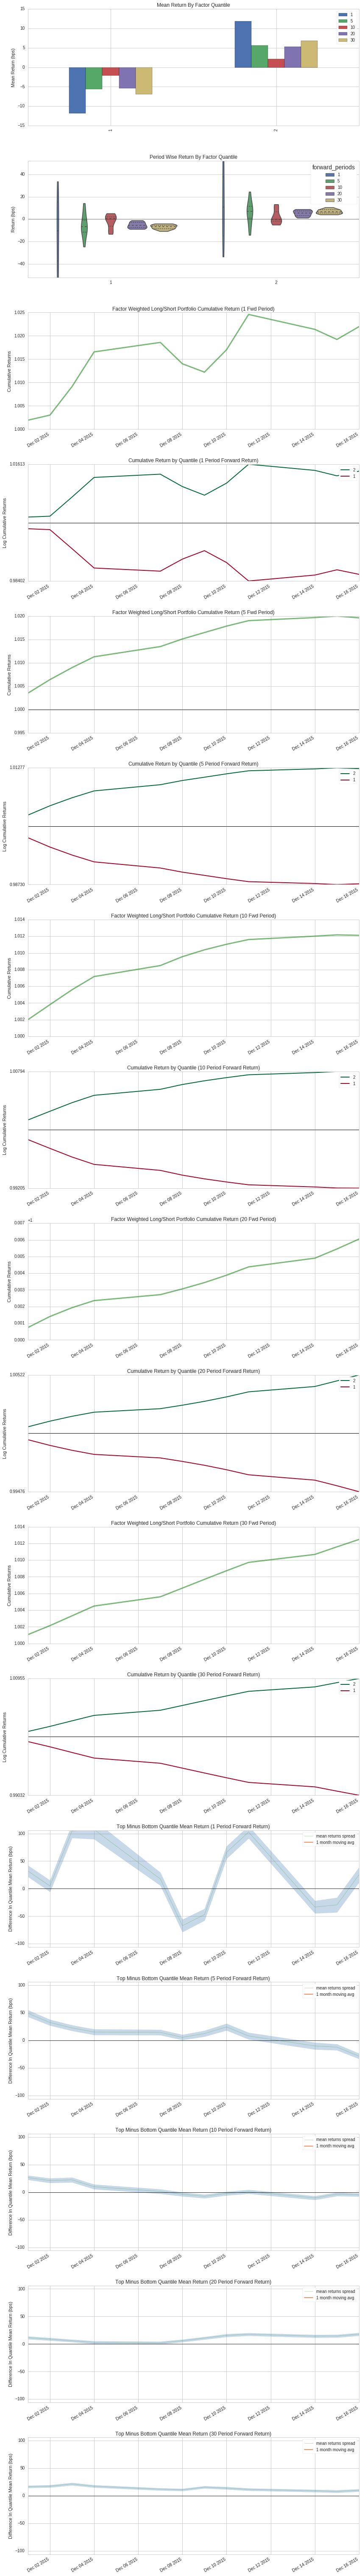

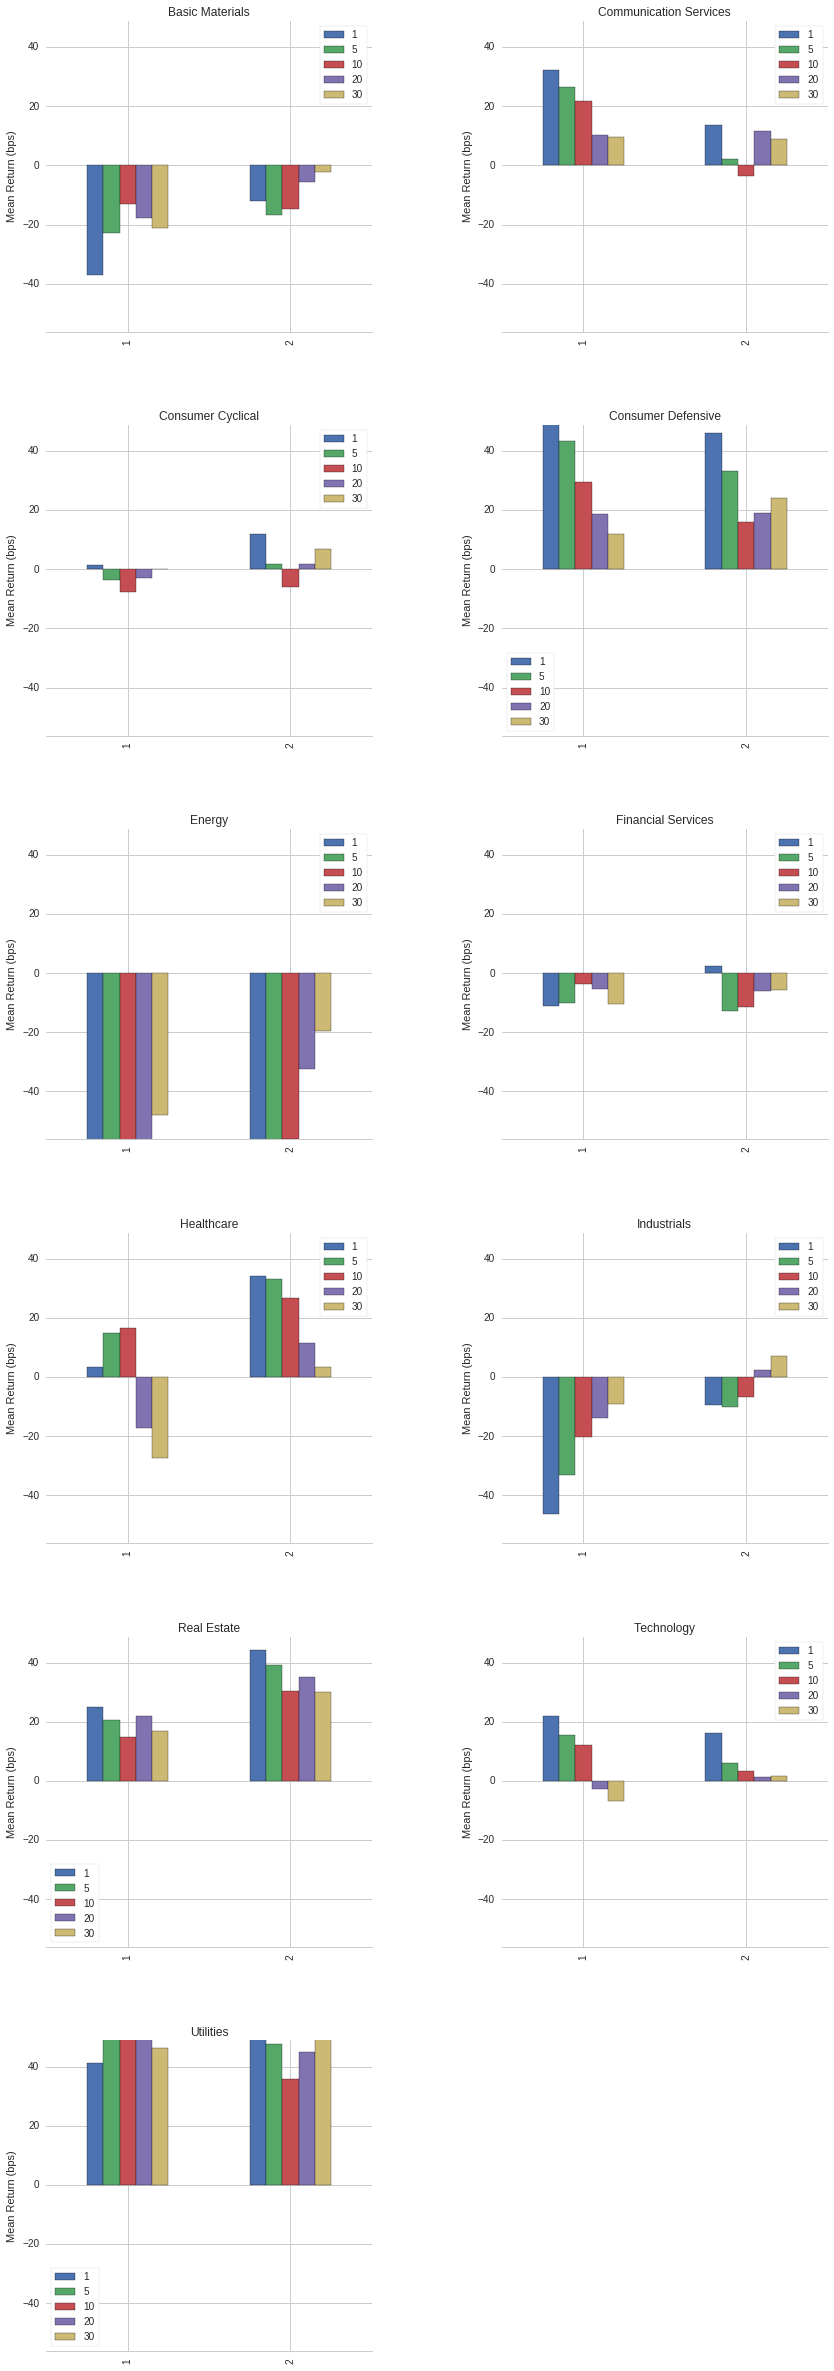

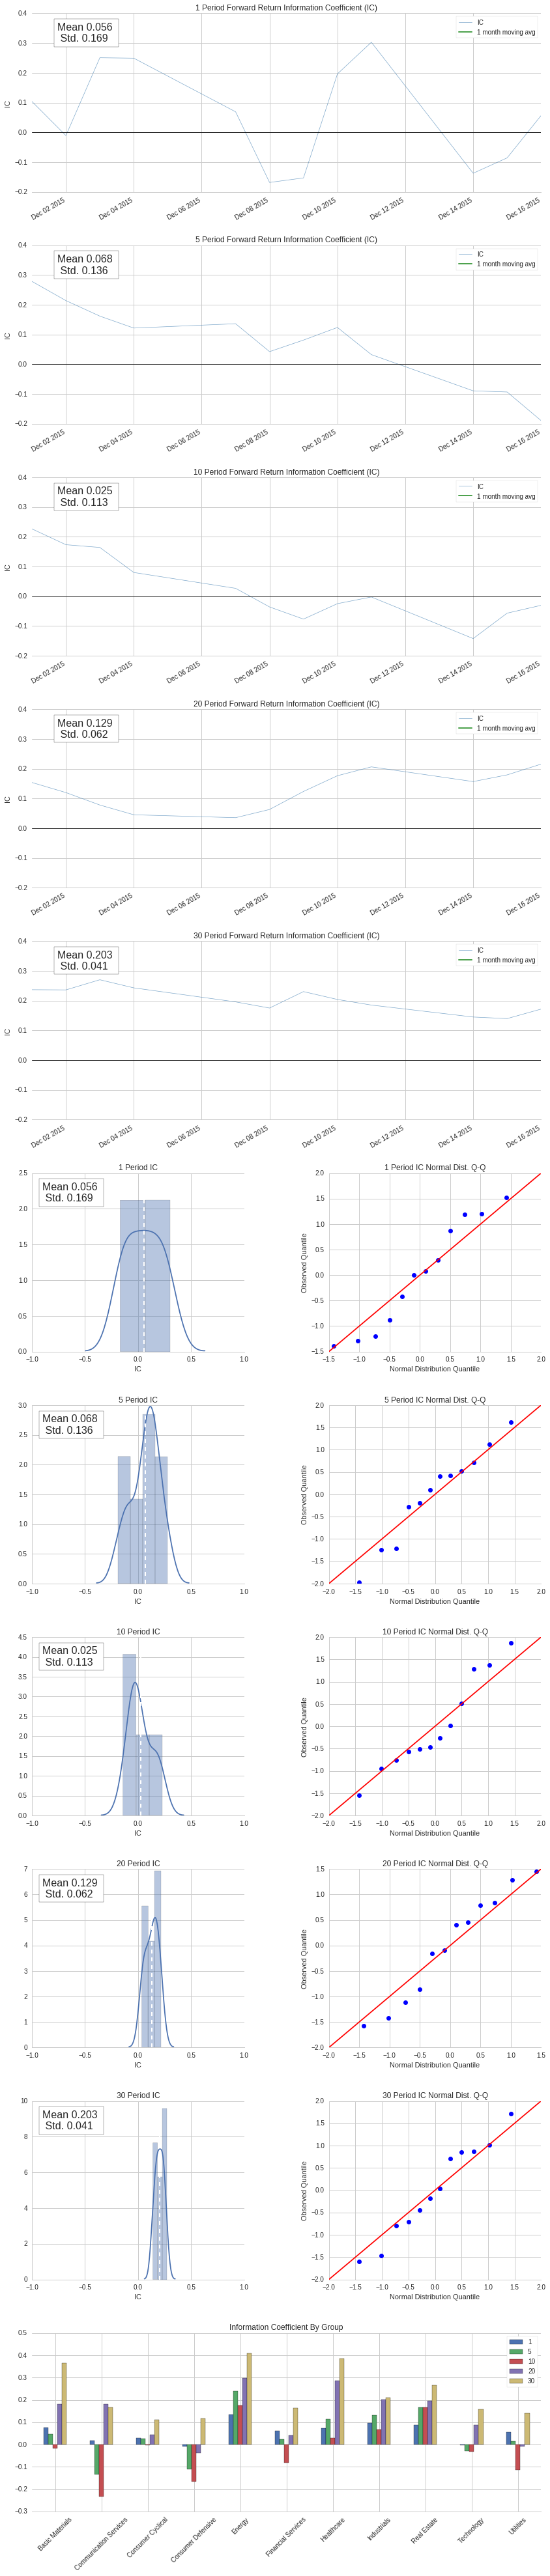

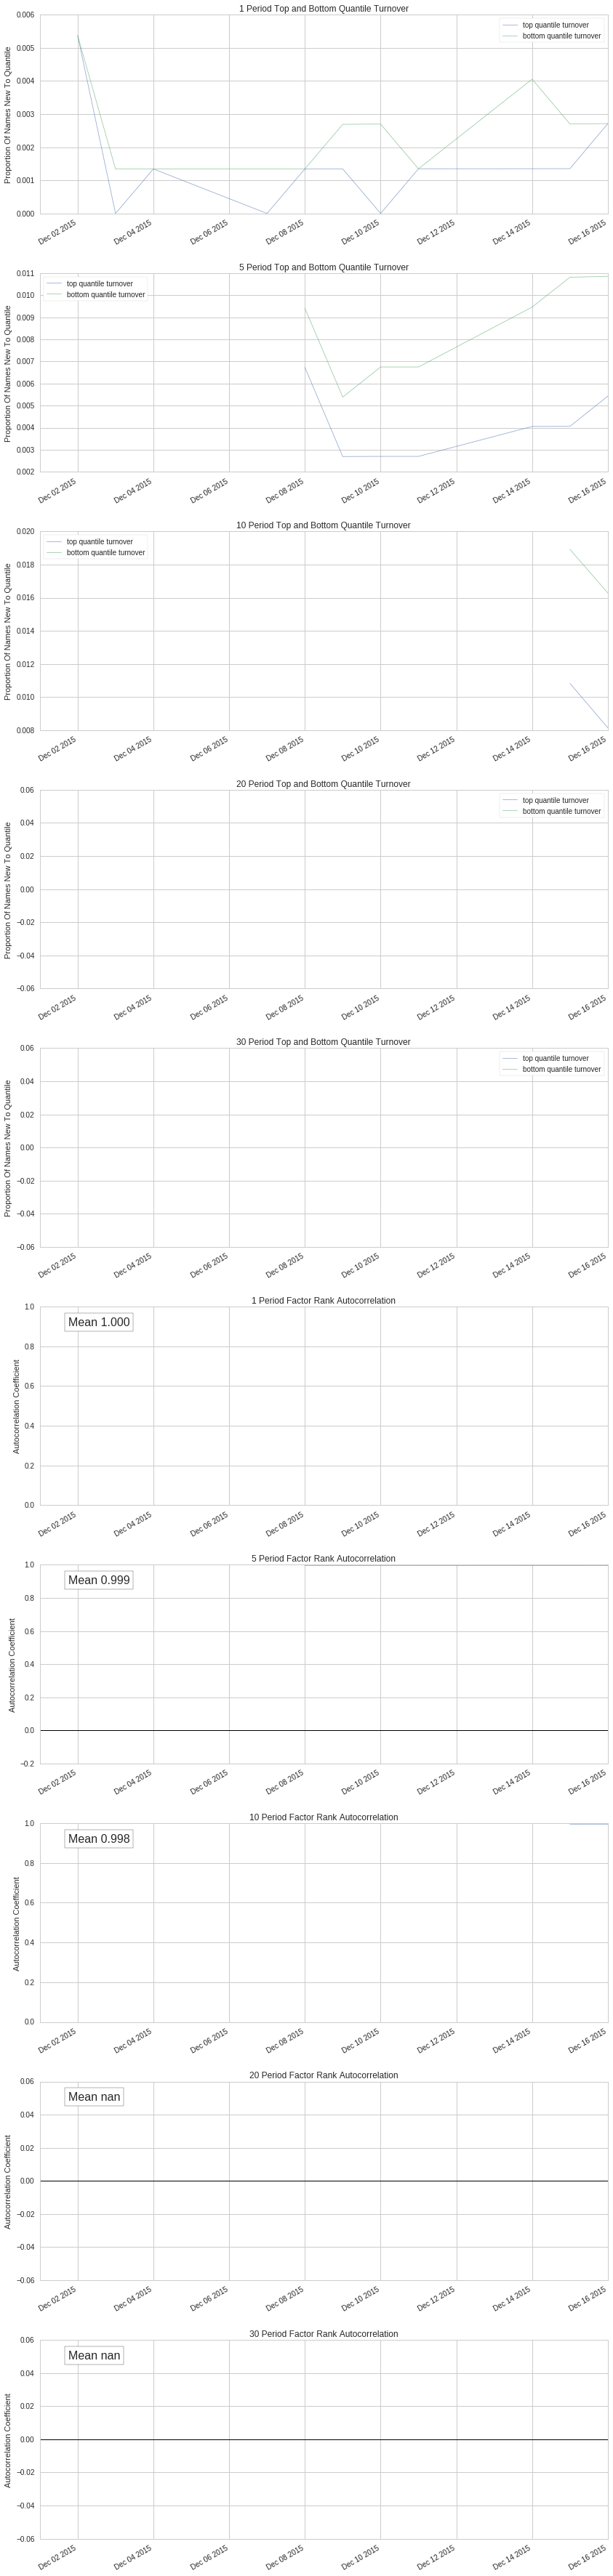

In [22]:
al.tears.create_full_tear_sheet(factor_data,by_group=True)